In [1]:
import antares

Loading ANTARES from /data0/sw/antares-kernel/lib/python3.9/site-packages/antares/__init__.py

        _    _   _ _____  _    ____  _____ ____
       / \  | \ | |_   _|/ \  |  _ \| ____/ ___|
      / _ \ |  \| | | | / _ \ | |_| |  _| \___ \\
     / ___ \| |\  | | |/ ___ \|  _ /| |___ ___| |
    /_/   \_\_| \_| |_/_/   \_\_| \_\_____|____/   v2.11.0
    


In [2]:
# Imports
import antares.devkit as dk
dk.init()
# You should see a happy message that says that "ANTARES DevKit is ready!"

2025-11-11 14:08:15,164 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use
2025-11-11 14:08:15,311 - WARNING MainThread settings.py:setup_prometheus:124 - Prometheus failed to start with [Errno 98] Address already in use


Jaeger tracer already initialized, skipping


Testing loading a random Locus with `dk.get_locus()`...

ANTARES v2.11.0 DevKit is ready!
Website: https://antares.noirlab.edu
Documentation: https://nsf-noirlab.gitlab.io/csdc/antares/antares/



In [4]:
# Define a Paczyński microlensing model
def paczynski(t, t0, u0, tE, F_s):
    """
    Paczyński microlensing light curve model
    t0 : peak time
    u0 : impact parameter
    tE : Einstein crossing time
    F_s : source flux
    F_b : blended flux
    """
    u = np.sqrt(u0**2 + ((t - t0) / tE) ** 2)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return F_s * (A) + (1-F_s)
    
def fit_paczynski(times, mags, flxs, flx_errs):
    """
    Fit the Paczyński microlensing model to flux data.
    Returns best-fit parameters and chi-squared value.
    """
    if len(times) < 4:
        return None, None  # Not enough data

    # initial guesses
    t0_guess = times[np.argmin(flxs)]
    u0_guess = 1.0 / (np.max(flxs))

    tE_guess = 20.0
    F0_guess = 0.5


    initial_guess = [t0_guess, u0_guess, tE_guess, F0_guess]

    bounds = (
                        [times.min() - 50, 0, 1.0, 0.0],
                        [times.max() + 50, np.inf, 500.0, 1]
                    )


    try:
        popt, _ = curve_fit(
            paczynski,
            times, flxs,
            p0=initial_guess,
            sigma=flx_errs,
            bounds=bounds,

            maxfev=5000
        )
        chi2 = np.sum(((flxs - paczynski(times, *popt)) / flx_errs) ** 2) / len(times)
        return popt, chi2
    except Exception as e:
        print(f"  Paczynski fitting error: {e}")
        return None, None

def mag_to_flux(mag, F0=1.0):
    """
    Convert magnitude to flux.
    
    Parameters:
    - mag : magnitude (float or array)
    - F0 : reference flux (zeropoint), default=1.0 for relative flux
    
    Returns:
    - flux : flux corresponding to the magnitude
    """
    flux = F0 * 10**(-0.4 * mag)
    flux = flux/np.min(flux)
    return flux
    
def magerr_to_fluxerr(mag, mag_err, F0=1.0):
    """
    Convert magnitude uncertainty to flux uncertainty.
    
    Parameters:
    - mag : magnitude value or array
    - mag_err : magnitude uncertainty value or array
    - F0 : zeropoint flux (default=1.0 for relative flux)
    
    Returns:
    - flux_err : flux uncertainty
    """
    flux = mag_to_flux(mag, F0)
    flux_err = 0.4 * np.log(10) * flux * mag_err
    return flux_err

# Writing a preliminary microlensing filter that reads in the photometry

In [6]:
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
from astropy.table import MaskedColumn
import warnings
import astropy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import skew

#from antares_microlensing_filter import microlensing

class microlensing(dk.Filter):    
    INPUT_LOCUS_PROPERTIES = [
        'ztf_object_id',
    ]

    REQUIRED_TAGS = ['lc_feature_extractor']

    OUTPUT_TAGS = [
        {
            'name': 'microlensing_candidate',
            'description': 'Locus - a transient candidate - exhibits a microlensing-like variability',
        }
    ]


    def make_lc(self, locus):

        with warnings.catch_warnings():
            # The cast of locus.timeseries: astropy.table.Table to a pandas
            # dataframe results in the conversion of some integer-valued
            # columns to floating point represntation. This can result in a
            # number of noisy warning so we will catch & ignore them for the
            # next couple of lines.
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
        
        dn = data.dropna()
        times=dn['ant_mjd'][dn['ztf_fid']==1]
        mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
        mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]
        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, mags_err)
        

    def is_known_other_phenomenon(self, locus, locus_params):
        """
        Method to check the locus' pre-existing parameters indicated that it has
        been identified or is likely to be a variable of a type other than microlensing

        :param locus:
        :param locus_params:
        :return: boolean
        """

        # Default result is not a known variable
        known_var = False
        
        # Tunable detection thresholds.
        # Ref: Sokolovsky et al. 2016: https://ui.adsabs.harvard.edu/abs/2017MNRAS.464..274S/abstract
        period_peak_sn_threshold = 20.0  # Based on tests with ZTF alerts
        stetson_k_threshold = 0.8  # The expected K-value for a constant lightcurve with Gaussian noise

        # Check for periodicity
        if locus_params['properties']['feature_period_s_to_n_0_magn_r'] >= period_peak_sn_threshold:
            known_var = True

        # Check Stetson-K index
        if locus_params['properties']['feature_stetson_k_magn_r'] <= stetson_k_threshold:
            known_var = True

        # Check whether this event is associated with a GW event
        if 'plausible_gw_events_assoc' in locus.alert.properties.keys():
            known_var = True

        # If the alert has parameters from JPL Horizons, then it is likely cause by
        # a Solar System object
        if 'horizons_targetname' in locus_params['properties'].keys():
            known_var = True

        # Check whether the ANTARES crossmatch against known galaxy catalogs threw up any matches
        # The locus.catalog_objects attribute is a dictionary of lists of known objects for each 
        # catalogs.  If a match has been found, then the key for the corresponding catalog will be 
        # in the list of keys.  So we can use that to check for matches with galaxy catalogs. 
        # Of those available in the list the Gemini NIR survey of known quasars is the closest
        if 'gnirs_dqs' in locus.catalog_objects.keys():
            known_var = True
            
        return known_var

    def calculate_eta(self, mag):
        """ Via puzle https://github.com/jluastro/puzle/blob/main/puzle/stats.py"""
        delta = np.sum((np.diff(mag)*np.diff(mag)) / (len(mag)-1))
        variance = np.var(mag)
        eta = delta / variance
        return eta

    def return_eta_residual_slope_offset(self):
        """ 
        Via puzle https://github.com/jluastro/puzle/blob/main/puzle/cands.py
        TODO is 6 months and a year - calculate slope and intercept based on real Rubin data
        """
        slope = 3.8187919463087248
        offset = -0.07718120805369133
        return slope, offset

    def is_microlensing_candidate(self, locus, times, mags, errors):
        """
        Example of a set of Microlensing detection criteria
        """
        if len(times) < 10:  # Too few data points
            return False

        # Extract the full parameter set from the locus and the alert
        locus_params = locus.to_dict()

        # Use the pre-calculated properties of the locus to eliminate those
        # which show signs of variability, e.g. in their periodicity signature or
        # the Stetson-K index
        known_var = self.is_known_other_phenomenon(locus, locus_params)
        if known_var:
            return False

        # Sort data by time
        sorted_idx = np.argsort(times)
        times, mags, errors = times[sorted_idx], mags[sorted_idx], errors[sorted_idx]

        # 1. Check for smoothness (low skewness means symmetric light curve)
        # TODO: Check for threshold with parallax and maybe remove or lower threshold
        if abs(skew(mags)) > 1:
            return False

        # TODO is 6 months and a year - calculate this based on percentile of real data
        eta_thresh = 1.255 # Avg from ZTF level 2 (low eta)
        # Do check for existance since if there's only one band of data, only one will exist
        eta_r_exists = 'feature_eta_e_magn_r' in locus_params['properties'].keys()
        eta_g_exists = 'feature_eta_e_magn_g' in locus_params['properties'].keys()
        eta_r = locus_params['properties']['feature_eta_e_magn_r']
        eta_g = locus_params['properties']['feature_eta_e_magn_g']
        if eta_r_exists and eta_g_exists:
            if eta_r >= eta_thresh and eta_g >= eta_thresh:
                return False
        elif eta_r_exists:
            if eta_r >= eta_thresh:
                return False
        elif eta_g_exists:
            if eta_g >= eta_thresh:
                return False

        # 2. Check variability (microlensing should have a clear peak)
        # Decrease threshold with longer baseline
        # Q for broker - 365 days or full lightcurve?
        if np.ptp(mags) < 0.5:  # Peak-to-peak magnitude difference
            return False

        flxs = mag_to_flux(mags)
        flx_errs = magerr_to_fluxerr(mags, errors)

        # 3. Perform a lightweight template fit (Paczyński model)

        popt, chi2_paczynski = fit_paczynski(times, mags, flxs, flx_errs)
        resid = flxs - paczynski(times, *popt)
        chi2 = np.sum((resid / flx_errs) ** 2) / len(times)

        # 4. Apply a simple chi2 threshold
        if chi2 < 2:  # Poor-fit light curves fails
            return True
        # except RuntimeError:
        #     return False  # Fit failed

        # 5. Check that the residual isn't correlated in all avaliable bands
        eta_resid = self.calculate_eta(resid)
        eta_slope, eta_offset = self.return_eta_residual_slope_offset()
        if eta_r_exists and eta_g_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset) and (eta_resid < eta_g*eta_slope + eta_offset):
                return False
        elif eta_r_exists:
            if (eta_resid < eta_r*eta_slope + eta_offset):
                return False
        elif eta_g_exists:
            if (eta_resid < eta_g*eta_slope + eta_offset):
                return False

        # TODO - Rache potentially query full lightcurve if not already there and if possible

        # TODO - Natasha add microlensing fit with BAGLE

        return True
    def run(self, locus):
        print('Processing Locus:', locus.locus_id)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", astropy.table.TableReplaceWarning)
            df = locus.timeseries.to_pandas()

        data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']].dropna()

        
        
        # Split into g-band and i-band
        for band in [1, 2]:  # 1 = g-band, 2 = i-band
            band_data = data[data['ztf_fid'] == band]
            times, mags, errors = band_data['ant_mjd'].values, band_data['ztf_magpsf'].values, band_data['ztf_sigmapsf'].values
            
            if self.is_microlensing_candidate(locus, times, mags, errors):
                print(f'Locus {locus.locus_id} is a microlensing candidate in band {band}')
                locus.tag('microlensing_candidate')
        
        
        return

In [7]:
def plot_lightcurve(locus):
    df = locus.timeseries.to_pandas()
    
    data = df[['ant_mjd', 'ztf_fid', 'ztf_magpsf', 'ztf_sigmapsf']]
    
    dn = data.dropna()
    times=dn['ant_mjd'][dn['ztf_fid']==1]
    mags = dn['ztf_magpsf'][dn['ztf_fid']==1]
    mags_err = dn['ztf_sigmapsf'][dn['ztf_fid']==1]

    plt.errorbar(times, mags, yerr=mags_err, marker = '.', linestyle = 'None')
    plt.gca().invert_yaxis()
    plt.show()

    return


In [8]:
# Execute the microlensing filter on the locus
report = dk.run_filter(microlensing, locus="ANT2023wuk92lk9fz76")


Processing Locus: ANT2023wuk92lk9fz76
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 1
Locus ANT2023wuk92lk9fz76 is a microlensing candidate in band 2


/data0/sw/antares-kernel/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
'feature_eta_e_magn_r' in report['locus_data'].to_dict()['properties'].keys()

True

In [10]:
print(report['new_tags'])

{'microlensing_candidate'}


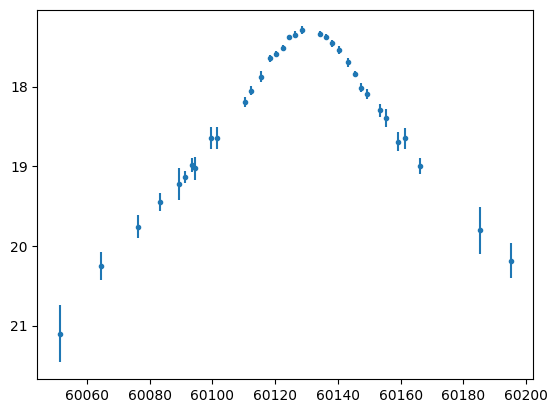

In [11]:
plot_lightcurve(report['locus_data'])

In [12]:
report = dk.run_many(microlensing, n=10)

# `run_many()` returns a report of what the filter did. Take a look at it:
print(report)

Processing Locus: ANT2020affnthq
Processing Locus: ANT2020vcgg2
Processing Locus: ANT2025zs5q06szzzen
Processing Locus: ANT2018i65xm
Processing Locus: ANT2020affnavi
Processing Locus: ANT2020affntiq
Processing Locus: ANT2020aemsmay
Processing Locus: ANT2023wkr0ax5e71je
Processing Locus: ANT2025f1l05lfj37to
Processing Locus: ANT2020aeugk6a
{'n': 10, 'results': [{'locus_id': 'ANT2020affnthq', 'locus_data': FilterContext(locus_id="ANT2020affnthq"), 't': 0.05999887999999842, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2020vcgg2', 'locus_data': FilterContext(locus_id="ANT2020vcgg2"), 't': 0.06061868100000112, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}, {'locus_id': 'ANT2025zs5q06szzzen', 'locus_data': FilterContext(locus_id="ANT2025zs5q06szzzen"), 't': 0.05934027899999883, 'new_locus_properties': {}, 'new_alert_properties': {}, 'new_tags': set(), 'raised_halt': False}

218.9305926301782
set()


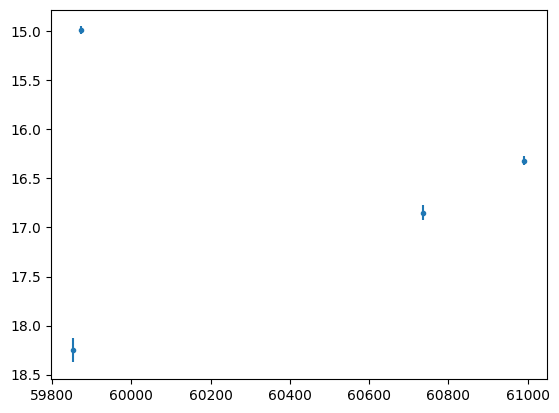

1.6112472342255189
set()


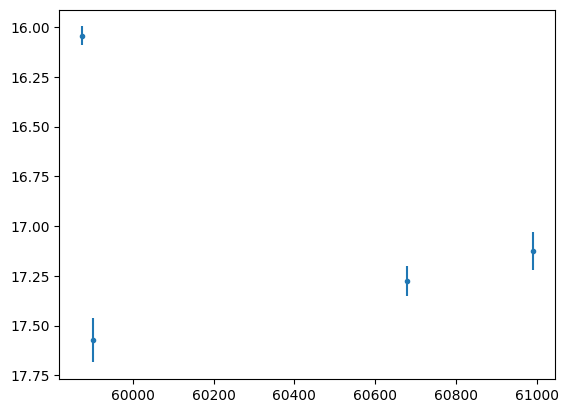

26.177951061582814
set()


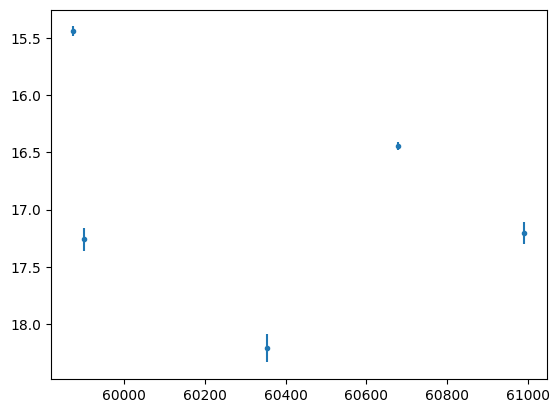

2.0000000000000004
set()


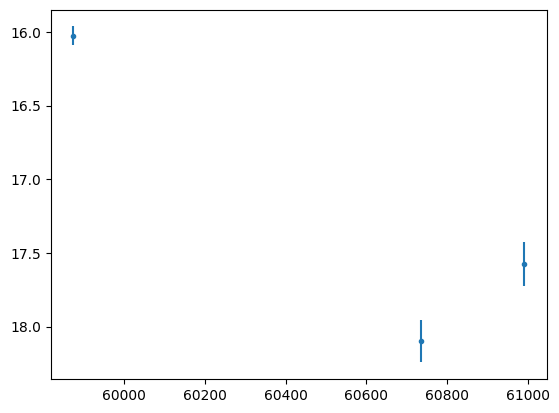

1.2142533322334312
set()


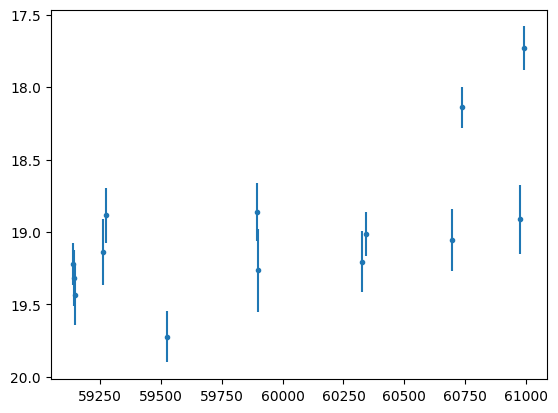

2.0000000000000004
set()


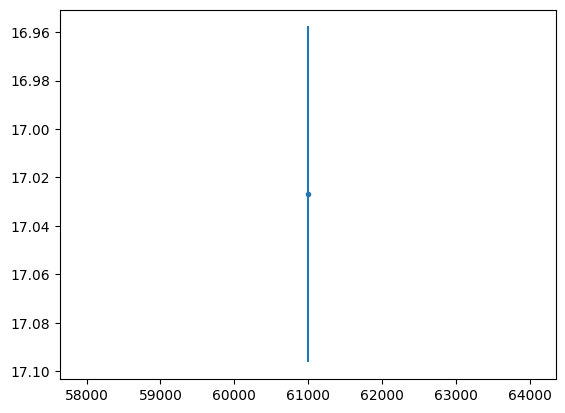

27.734683397941357
set()


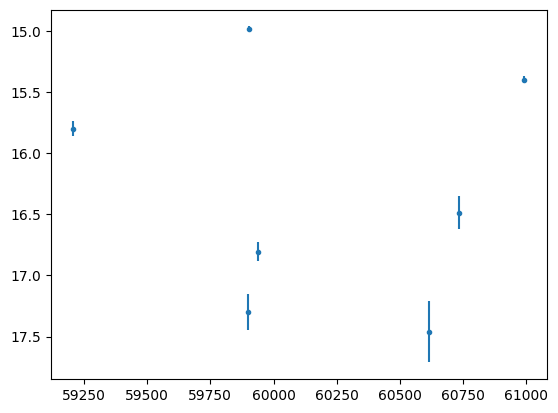

In [14]:
for result in report['results']:
    try:
        print(result['locus_data'].to_dict()['properties']['feature_eta_e_magn_r'])
    except:
        continue
    print(result['new_tags'])
    plot_lightcurve(result['locus_data'])

In [15]:
report['results'][-2]['locus_data'].timeseries.to_pandas()

,alert_id,ant_dec,ant_mag,ant_magerr,ant_maglim,ant_mjd,ant_passband,ant_ra,ant_survey,ant_time_received,...,ztf_tblid,ztf_tooflag,ztf_xpos,ztf_ypos,ztf_zpclrcov,ztf_zpmed,ant_mag_corrected,ant_magerr_corrected,ant_magulim_corrected,ant_magllim_corrected
time,,,,,,,,,,,,,,,,,,,,,
2025-10-13 10:33:22.003209,ztf_upper_limit:ZTF21aaakpjc-3207439832115,NaN,NaN,NaN,20.145201,60961.439838,R,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-18 09:00:20.001581,ztf_upper_limit:ZTF21aaakpjc-3212375232115,NaN,NaN,NaN,19.761299,60966.375231,g,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16.335694,16.432460
2025-10-18 09:33:49.000300,ztf_upper_limit:ZTF21aaakpjc-3212398482115,NaN,NaN,NaN,19.906799,60966.398484,R,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-20 11:02:52.002259,ztf_upper_limit:ZTF21aaakpjc-3214460322115,NaN,NaN,NaN,20.352699,60968.460324,R,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-24 11:04:21.002862,ztf_upper_limit:ZTF21aaakpjc-3218461352115,NaN,NaN,NaN,20.344400,60972.461354,g,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16.355101,16.411633
2025-10-24 12:03:53.997121,ztf_upper_limit:ZTF21aaakpjc-3218502702115,NaN,NaN,NaN,20.335899,60972.502708,R,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-10-26 12:03:18.002869,ztf_upper_limit:ZTF21aaakpjc-3220502292115,NaN,NaN,NaN,20.518900,60974.502292,g,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16.359198,16.407334
2025-10-29 09:28:08.999046,ztf_upper_limit:ZTF21aaakpjc-3223394542115,NaN,NaN,NaN,20.128099,60977.394549,g,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16.349047,16.418048
2025-10-31 10:33:03.003835,ztf_upper_limit:ZTF21aaakpjc-3225439612115,NaN,NaN,NaN,20.507401,60979.439618,R,NaN,2,1762868338,...,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
